6/21/2022

Code to test bending mode implementation.

In [1]:
using Revise

In [ ]:
using MKL # should give a speed up. Check below that the MKL library actually loads. May cause error on Apple machines.
using JuliaSpectra
using Plots
using LinearAlgebra
BLAS.get_config()

In [9]:
bounds = (l=[-1,1], J = 1/2:7/2, I=1/2, Σ=[-1/2,1/2], Λ=0, S = 1/2, F=0:4, M=-4:4)
basisX = enumerate_states(LinearCaseA_Bend_Field, bounds)

bounds = (l=[-1,1], J = 1/2:5/2, I=1/2, N=1:1, Λ=0, S = 1/2, F=0:4, M=-4:4)
basisX = enumerate_states(LinearCaseB_Bend_Field, bounds)
;

In [10]:
const sol = 299792458

const B = 7348.40052
const γ = -81.1538184
const qv = -20.0
const b=4.80
const c = 2.46
const μB = 1.4
const gS = 2.0023
const μel = 1.9 * 0.5034
;

In [14]:
Elist = range(1e-8, stop=500, length=1000)

# X State
Hrot = B * Rotation
Hsr = γ* SpinRotation
Hhf = (b+c/3) * HyperfineFermi + c * Hyperfine_Dipolar_c
Hld = qv * lDoubling
HX0 = Hrot + Hsr + Hhf + Hld
@time eigsysX = eigenshuffle(HX0, μel*Stark, basisX, Elist, pack_eigensystem=true, warn_if_lost=false)
;

  0.183626 seconds (375.29 k allocations: 81.760 MiB, 10.19% gc time)


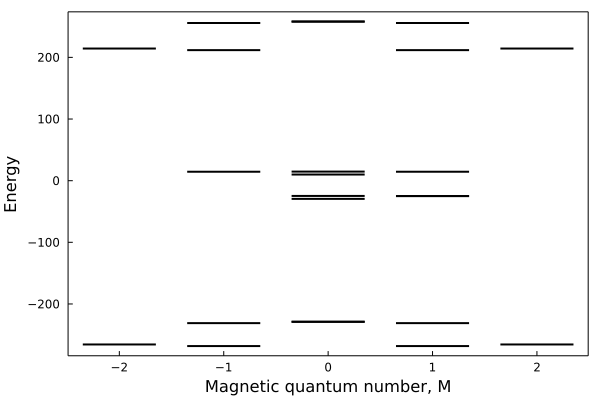

In [15]:
plotZeemanlevels(eigsysX[1:24,end], energy_offset = 7355, units="cm-1", ylabel="Energy", legend=false, lw=2, color=:black)

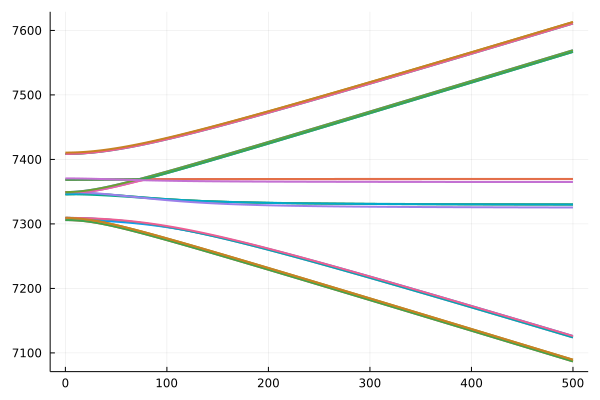

In [16]:
plot(Elist,eigsysX[1:24,:].E',legend=false, lw=2)

# A state

In the basis of Li and Coxon, using a parity case (a) basis, you get a 4x4 block for each J labeled by the basis states $ \lvert ^2\Delta_{5/2}; \pm \rangle$,  $ \lvert ^2\Delta_{3/2}; \pm \rangle$, $ \lvert \kappa ^2\Sigma; \pm \rangle$, $ \lvert \mu ^2\Sigma; \pm \rangle$, where $\pm$ refers to e/f parity. So in a non-parity basis, each $J$ should give rise to an 8x8 block.

In [16]:
bounds = (l=[-1,1], J = 9/2, I=0, Λ=[-1,1], S = 1/2, M=1/2)
basis = enumerate_states(LinearCaseA_Bend_Field, bounds)


8-element Vector{LinearCaseA_Bend_Field}:
 |Λ = -1.0, l = -1.0, S = 0.5, Σ = -0.5, J = 4.5, Ω = -1.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = -1.0, l = -1.0, S = 0.5, Σ = 0.5, J = 4.5, Ω = -0.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = -1.0, l = 1.0, S = 0.5, Σ = -0.5, J = 4.5, Ω = -1.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = -1.0, l = 1.0, S = 0.5, Σ = 0.5, J = 4.5, Ω = -0.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = 1.0, l = -1.0, S = 0.5, Σ = -0.5, J = 4.5, Ω = 0.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = 1.0, l = -1.0, S = 0.5, Σ = 0.5, J = 4.5, Ω = 1.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = 1.0, l = 1.0, S = 0.5, Σ = -0.5, J = 4.5, Ω = 0.5, I = 0.0, F = 4.5, M = 0.5>
 |Λ = 1.0, l = 1.0, S = 0.5, Σ = 0.5, J = 4.5, Ω = 1.5, I = 0.0, F = 4.5, M = 0.5>

Test "tuple constants" method.